## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression,LinearRegression, Ridge, SGDRegressor,Lasso
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score,cross_val_predict
from mlxtend.plotting import plot_learning_curves


## Read File

In [5]:
df=pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [6]:
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [7]:
df['season']=df.season.replace({1:"spring",2:"summer",3:"fall",4:"winter"})
df['weathersit']=df.weathersit.replace({1:"Clear_Few Clouds",2:"Mist_cloudy",3:"Light rain_Light snow_Thunderstorm",4:'Heavy Rain_Ice Pallets_Thunderstorm_Mist'})
df['yr']=df.yr.replace([0,1],[2011,2012])
df['weekday']=df.weekday.replace([0,1,2,3,4,5,6],["sun","mon","tue","wed","thu","fri","sat"])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    object 
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    object 
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    object 
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(8), object(4)
memory usage: 91.5+ KB


# Clean Dataset

## Find Outliers

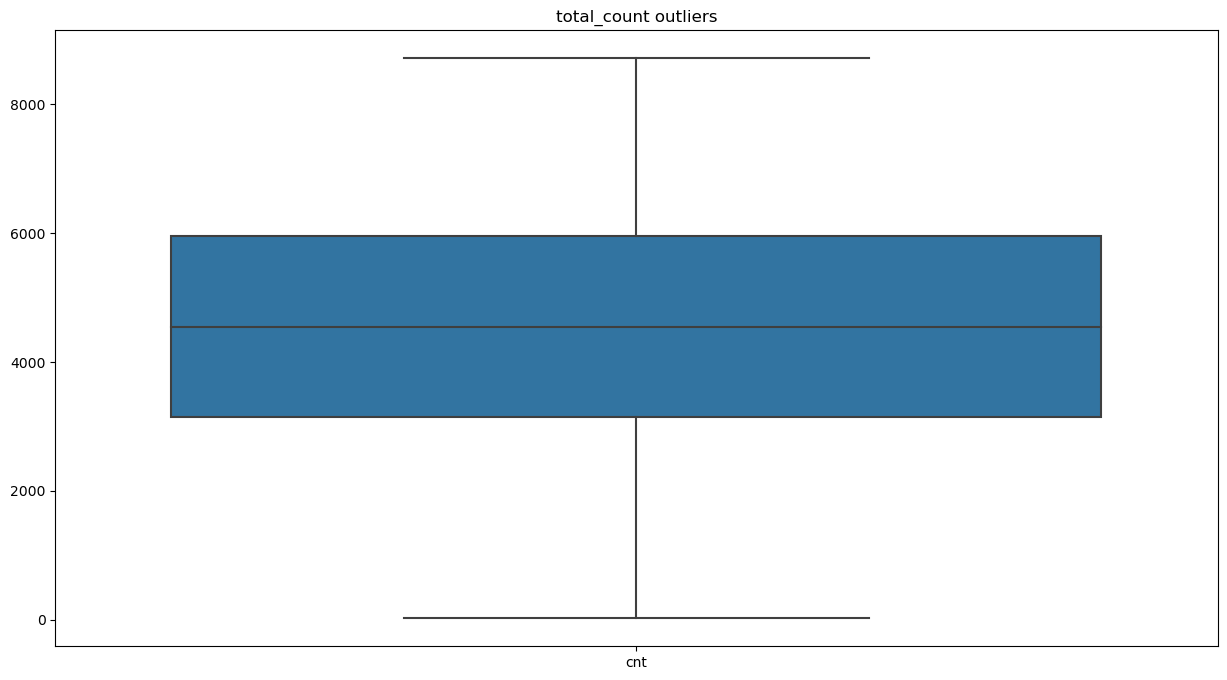

In [9]:
fig,ax=plt.subplots(figsize=(15,8))
sns.boxplot(data=df[['cnt']])
ax.set_title('total_count outliers')
plt.show()

### There is no outliers data in cnt feature

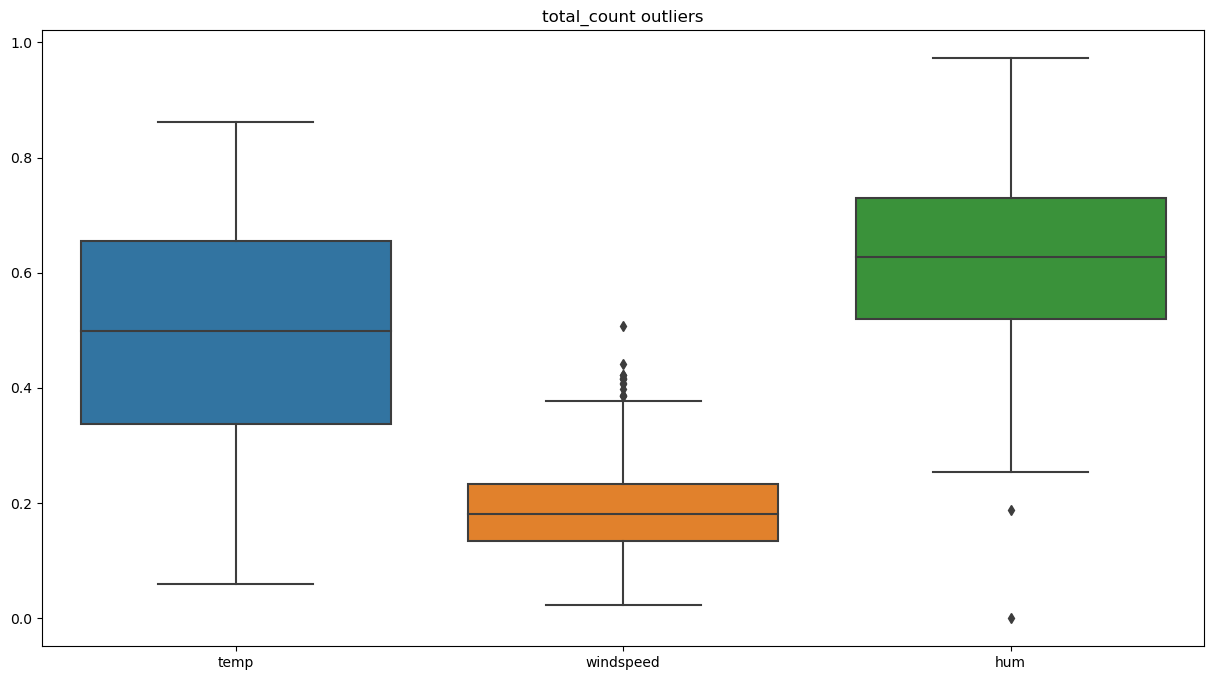

In [10]:
fig,ax=plt.subplots(figsize=(15,8))

sns.boxplot(data=df[['temp','windspeed','hum']])
ax.set_title('total_count outliers')
plt.show()

### There are some outliers in windspeed and hum feature

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
cols = ['windspeed','hum']
Q1=df.quantile(0.25)
Q3=df.quantile(0.75)
IQR=Q3-Q1
df =df[ ~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)].reset_index()
df.describe()

,index,instant,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt
count,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000
mean,365.779637,366.779637,2011.499303,6.562064,0.029289,0.684798,0.497365,0.476252,0.631562,0.186287,856.944212,3675.899582,4532.843794
std,210.971354,210.971354,0.500349,3.439113,0.168732,0.464921,0.183617,0.163155,0.139222,0.071786,689.273998,1557.676255,1933.542429
min,0.000000,1.000000,2011.000000,1.000000,0.000000,0.000000,0.059130,0.079070,0.254167,0.022392,2.000000,20.000000,22.000000
25%,184.000000,185.000000,2011.000000,4.000000,0.000000,0.000000,0.337500,0.337939,0.524583,0.134329,318.000000,2545.000000,3214.000000
50%,364.000000,365.000000,2011.000000,7.000000,0.000000,1.000000,0.505833,0.491783,0.630833,0.178496,727.000000,3681.000000,4570.000000
75%,549.000000,550.000000,2012.000000,10.000000,0.000000,1.000000,0.656667,0.611121,0.732917,0.230721,1120.000000,4807.000000,6031.000000
max,730.000000,731.000000,2012.000000,12.000000,1.000000,1.000000,0.861667,0.840896,0.972500,0.378108,3410.000000,6946.000000,8714.000000


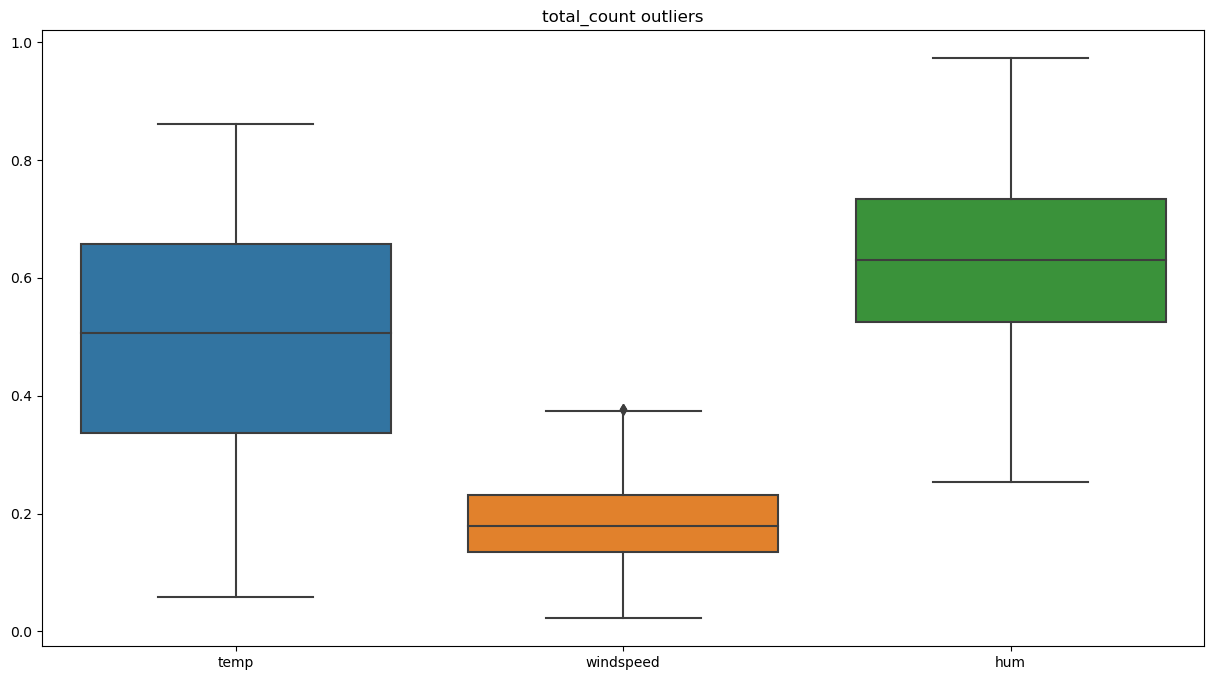

In [13]:
fig,ax=plt.subplots(figsize=(15,8))

sns.boxplot(data=df[['temp','windspeed','hum']])
ax.set_title('total_count outliers')
plt.show()

## Change numerical columns to categorical

In [14]:
df['season']=df.season.astype('object')
df['yr']=df.yr.astype('object')
df['mnth']=df.mnth.astype('object')
df['holiday']=df.holiday.astype('object')
df['weekday']=df.weekday.astype('object')
df['workingday']=df.workingday.astype('object')
df['weathersit']=df.weathersit.astype('object')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       717 non-null    int64  
 1   instant     717 non-null    int64  
 2   dteday      717 non-null    object 
 3   season      717 non-null    object 
 4   yr          717 non-null    object 
 5   mnth        717 non-null    object 
 6   holiday     717 non-null    object 
 7   weekday     717 non-null    object 
 8   workingday  717 non-null    object 
 9   weathersit  717 non-null    object 
 10  temp        717 non-null    float64
 11  atemp       717 non-null    float64
 12  hum         717 non-null    float64
 13  windspeed   717 non-null    float64
 14  casual      717 non-null    int64  
 15  registered  717 non-null    int64  
 16  cnt         717 non-null    int64  
dtypes: float64(4), int64(5), object(8)
memory usage: 95.4+ KB


## Find correlation's of columns

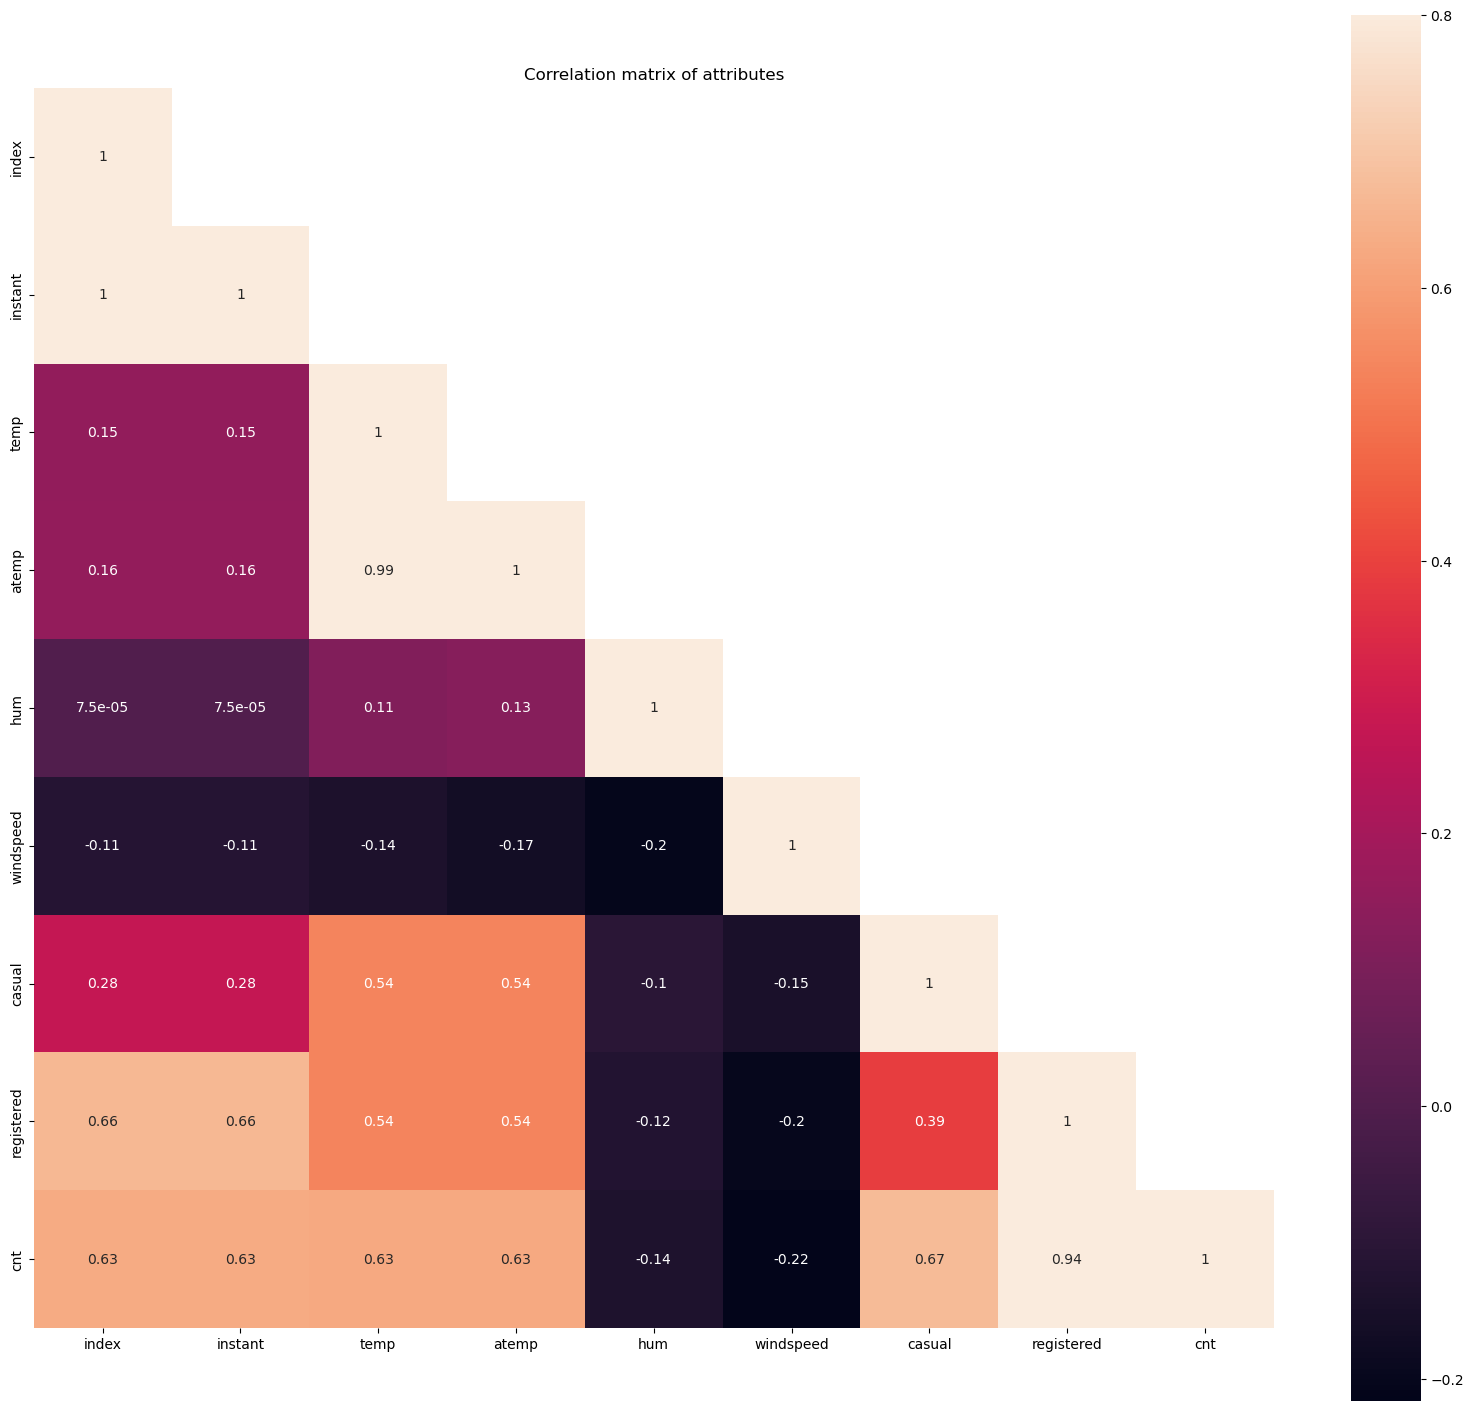

In [16]:
correMtr=df.corr()
mask=np.array(correMtr)
mask[np.tril_indices_from(mask)]=False
#Heat map for correlation matrix of attributes
fig,ax=plt.subplots(figsize=(20,18))
sns.heatmap(correMtr,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)
ax.set_title('Correlation matrix of attributes')
plt.show()

### as we can see the temp and atemp have very high correlation together and it means that they are carrying same information and it has negetive impact to models so i drop atemp column,Onthe other hand both columns(casual and registered) have very high correlation with CNT so i will drop them also. 
### and also can check below plots to for get same result

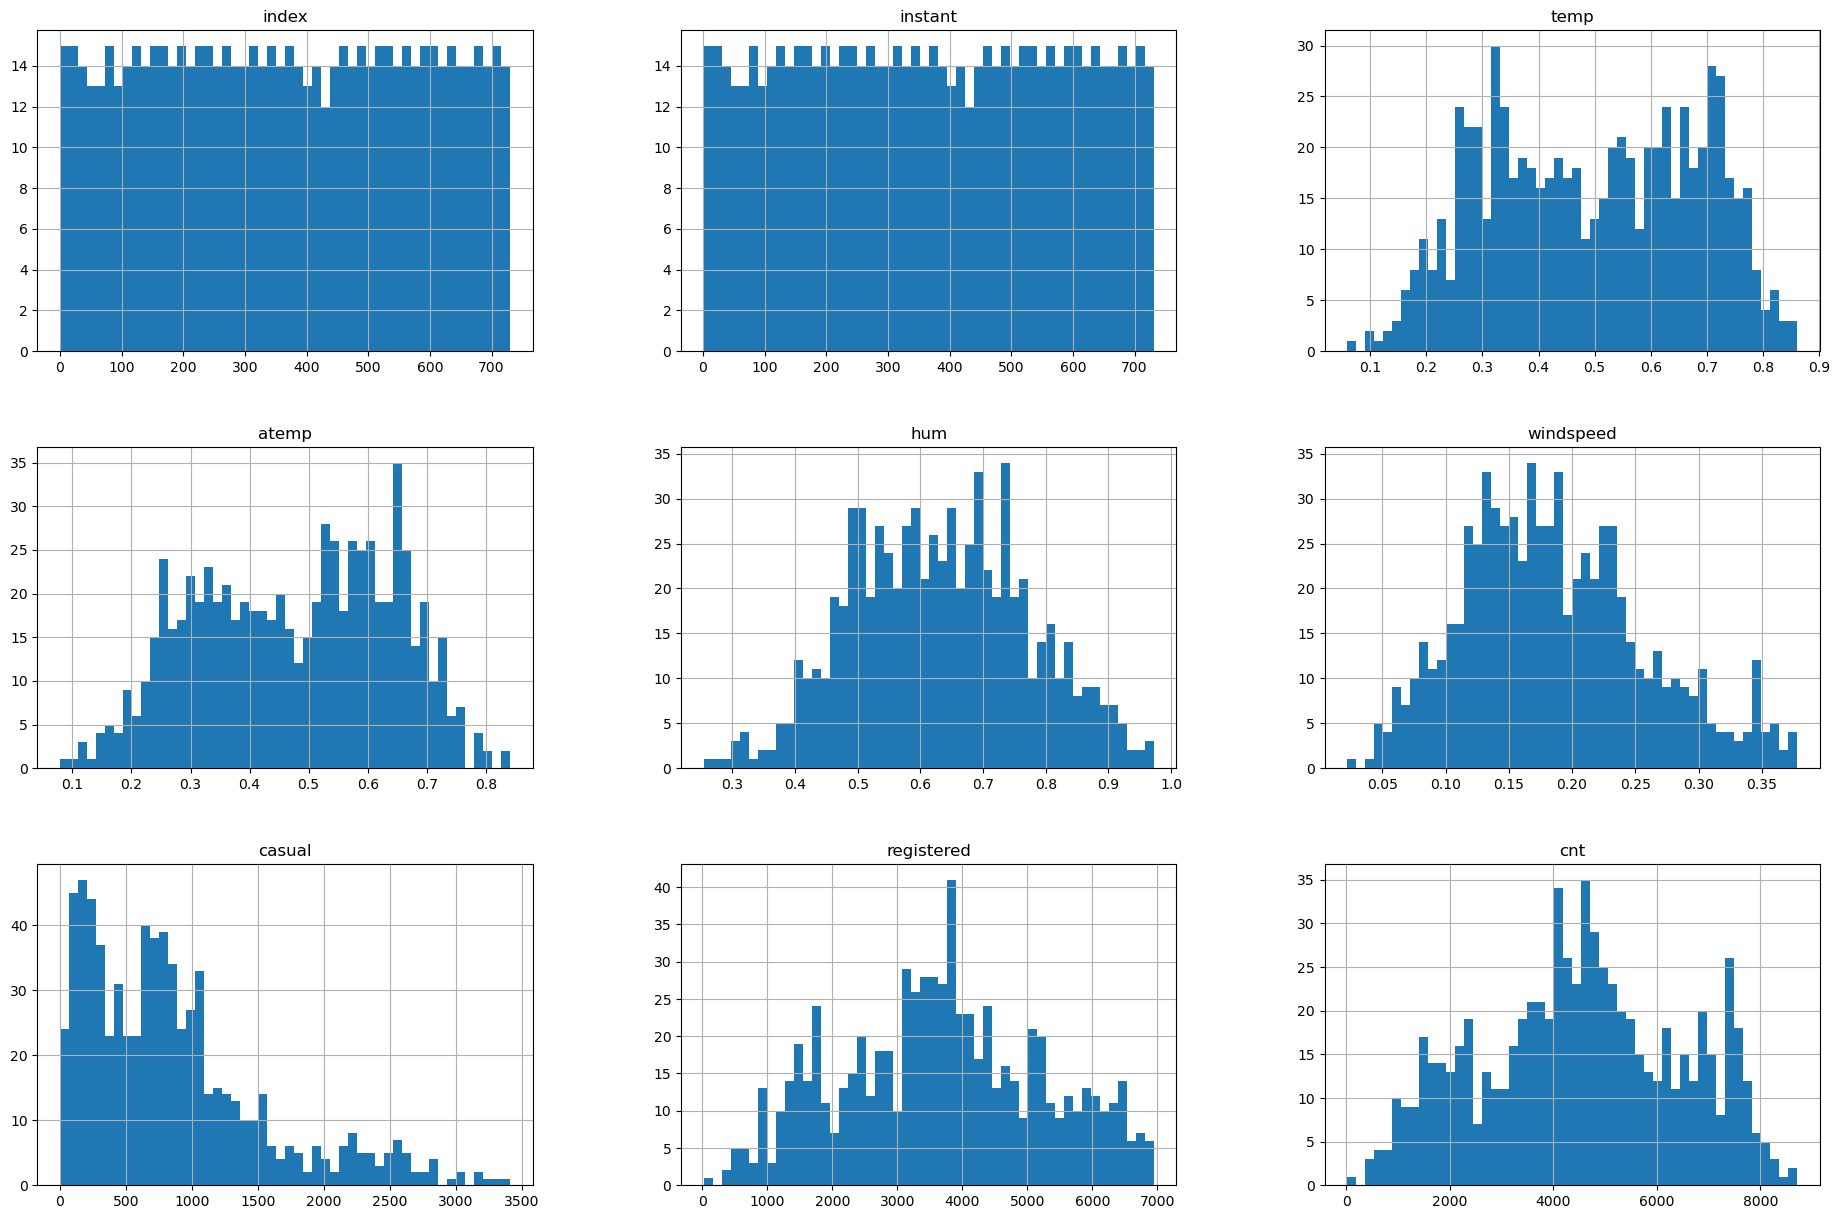

In [17]:
df.hist(bins=50, figsize=(23,15))
plt.show()

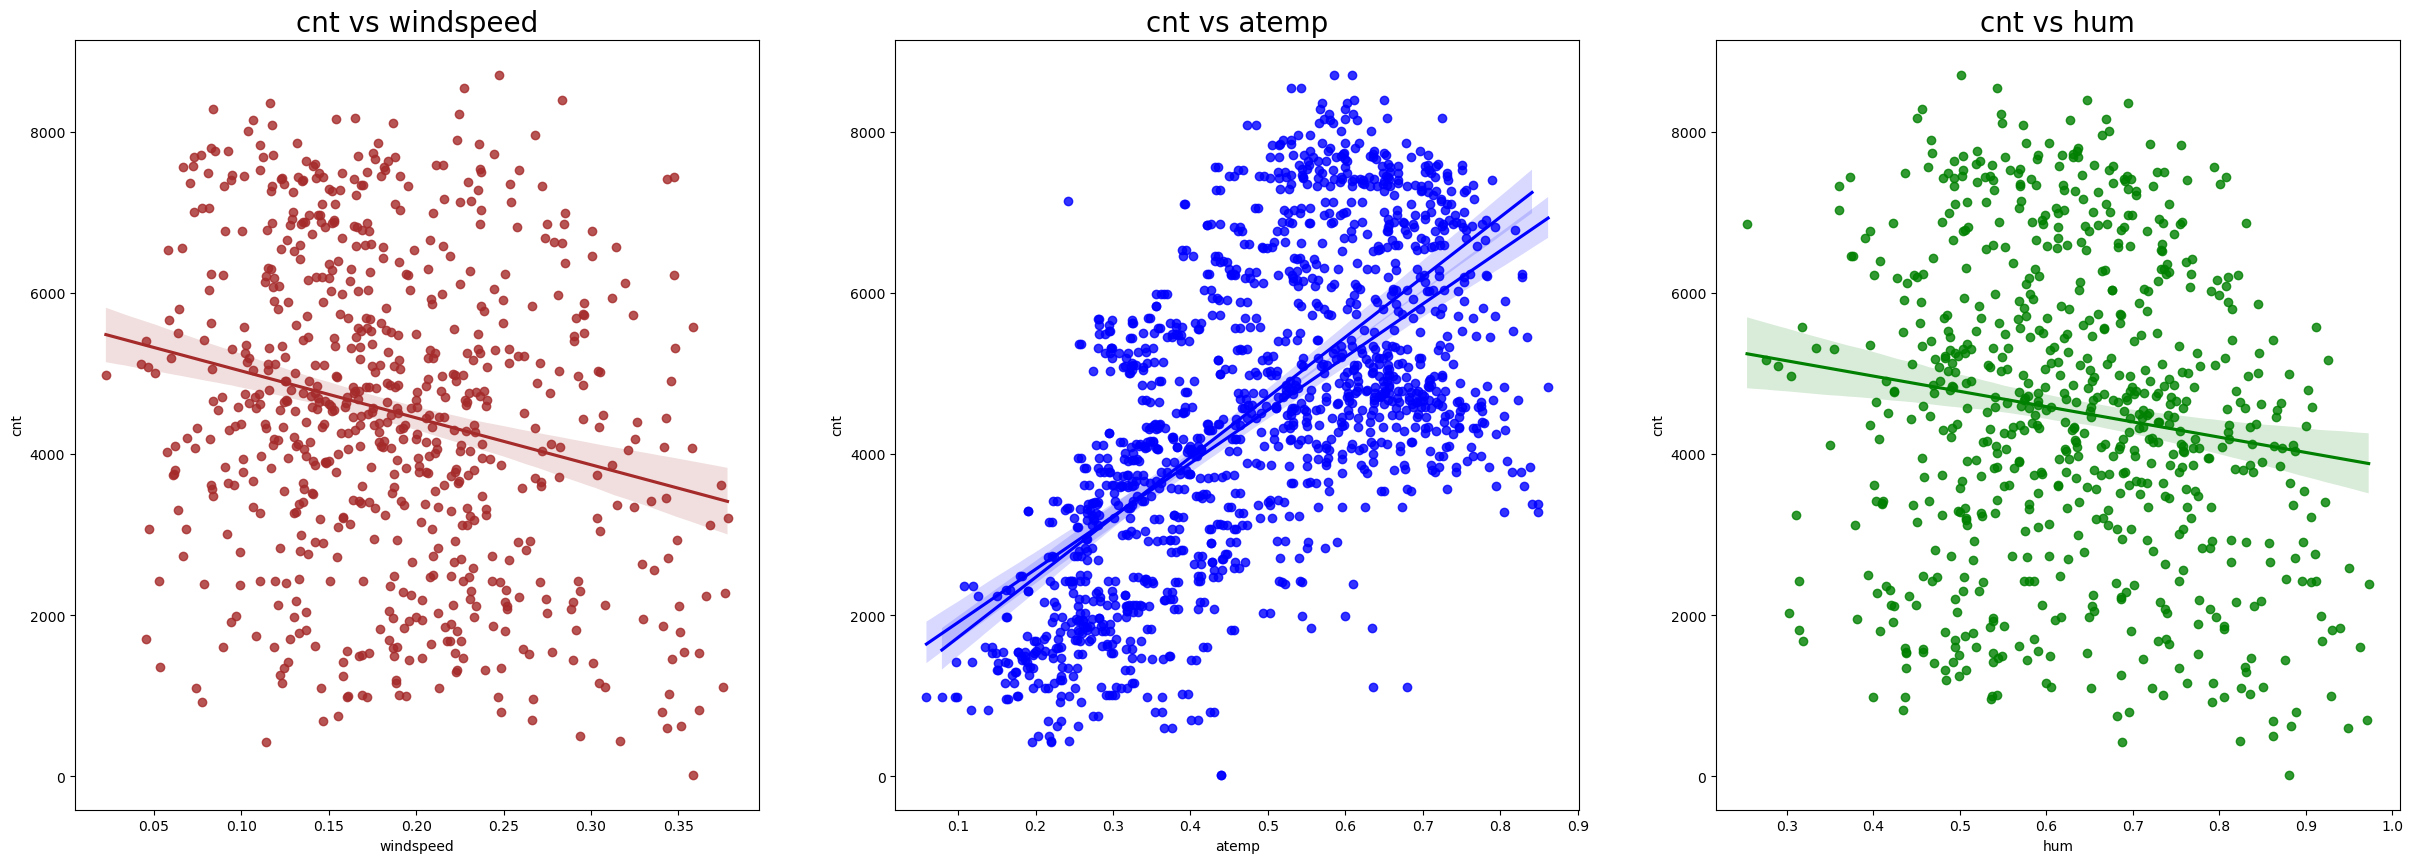

In [18]:

plt.figure(figsize=(30,10))

plt.subplot(1, 3 , 1)
plt.title("cnt vs windspeed", size=20)
sns.regplot(data=df, x="windspeed", y="cnt",color="brown")

plt.subplot(1, 3 , 2)
plt.title("cnt vs temp", size=20)
sns.regplot(data=df, x="temp", y="cnt",color="b")

plt.subplot(1, 3 , 2)
plt.title("cnt vs atemp", size=20)
sns.regplot(data=df, x="atemp", y="cnt",color="b")

plt.subplot(1, 3 , 3)
plt.title("cnt vs hum", size=20)
sns.regplot(data=df, x="hum", y="cnt",color="g" )

plt.savefig("scatter plot using linear regression")
plt.show()

as we can see from above scatter plot there is a linear relation between temp and number of bike rented.
also we can see this relation in atemp feature when the weather become hot the number of rented biks is become more and more
so as the result these two features (Temp and atemp) have same distribution and may molticolnearity so we can drop one of them.

## Boxplot for categorical features

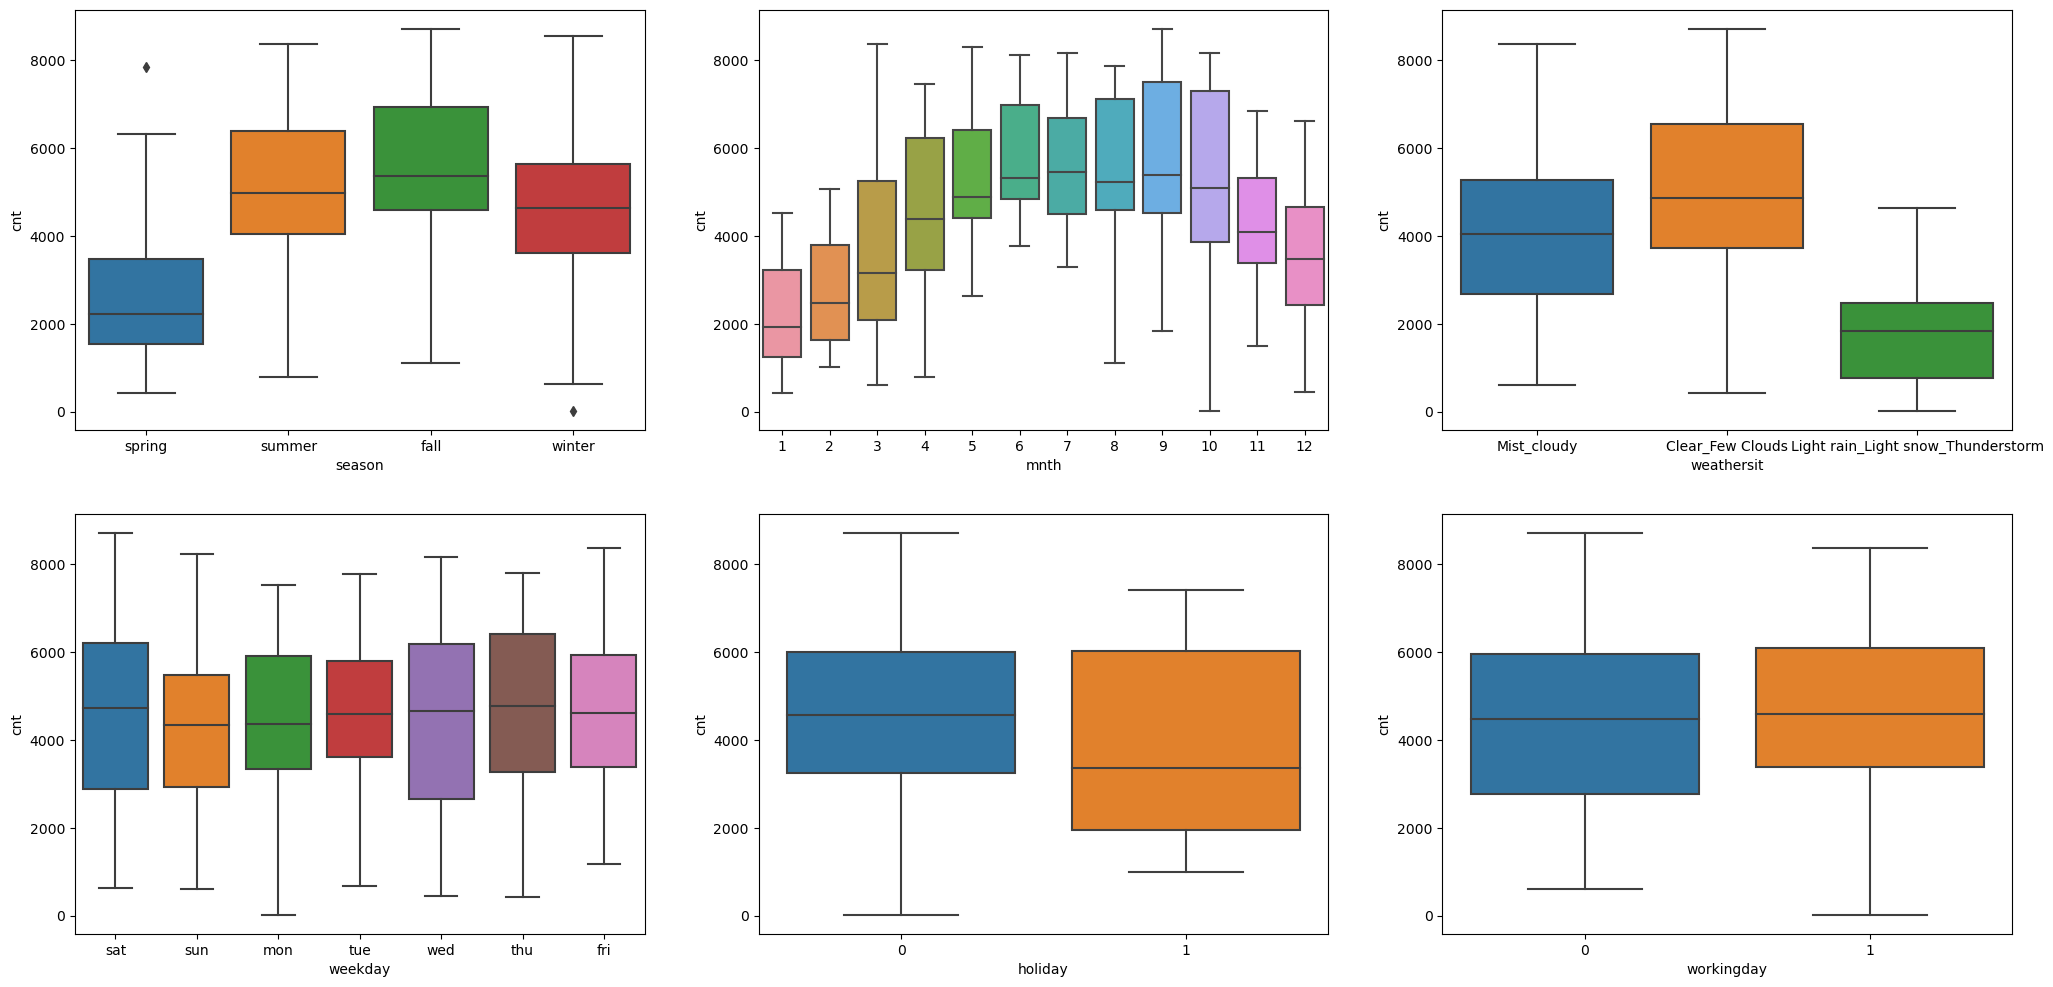

In [19]:
plt.figure(figsize=(25,12))
cat_vars = ["season", "mnth","weathersit","weekday","holiday","workingday"] 
i = 1
for var in cat_vars:
    
    plt.subplot(2,3,i)
    sns.boxplot(x=var, y = "cnt", data=df)
    i+=1
    
plt.show()

## Drop useless columns

### also drop dteday because we already have seperate columns for 'year' & 'month',

### Index and instant columns are index so drop them

In [20]:
df=df.drop(['index','instant','dteday','atemp','casual','registered'],axis=1)

# Change categorical columns

In [21]:
s =df.dtypes == 'object'
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ',len(object_cols))

Categorical variables:
['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
No. of. categorical features:  7


In [22]:
df = pd.get_dummies(df, columns = object_cols,drop_first=True)
df

,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,yr_2012,mnth_2,mnth_3,...,holiday_1,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,workingday_1,weathersit_Light rain_Light snow_Thunderstorm,weathersit_Mist_cloudy
0,0.344167,0.805833,0.160446,985,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.363478,0.696087,0.248539,801,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0.196364,0.437273,0.248309,1349,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0.200000,0.590435,0.160296,1562,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0.226957,0.436957,0.186900,1600,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,0.254167,0.652917,0.350133,2114,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,1
713,0.253333,0.590000,0.155471,3095,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
714,0.253333,0.752917,0.124383,1341,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
715,0.255833,0.483333,0.350754,1796,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


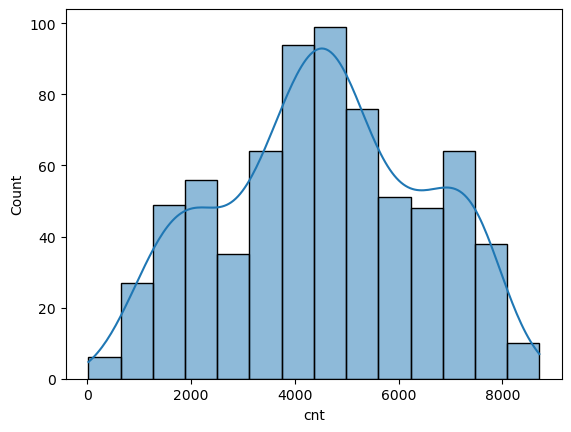

In [23]:
sns.histplot(df["cnt"], kde=True)
plt.show()

# Model prepration

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
scaler = MinMaxScaler()

In [26]:
num_vars = ['temp', 'temp', 'hum', 'windspeed','cnt']

df[num_vars] = scaler.fit_transform(df[num_vars])

In [27]:
X = df.drop(['cnt'],axis=1).values
y = df['cnt'].values



In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [34]:
def Model(model):
    
    print(f"Model MSE :  {metrics.mean_squared_error(y_test,y_predict)}")
    print(f"R2_SCORE : { metrics.r2_score(y_test, y_predict)}")



# 1.Linear Regression

In [35]:
from sklearn import linear_model

In [36]:
linear = LinearRegression()
linear.fit(X_train, y_train)
y_predict= linear.predict(X_test)


In [37]:
Model(linear)

Model MSE :  0.007821949250176152
R2_SCORE : 0.8417913293543581


In [38]:
from sklearn.metrics import mean_squared_error


## Comparing training and testing accuracy¶


In [39]:
mse1= mean_squared_error(y_test, y_predict)*100
training1 = linear.score(X_train, y_train)
testing1 = linear.score(X_test, y_test)
print(f'mse : {mse1/100}\ntraning score: {training1}\ntesting score: {testing1}')

mse : 0.007821949250176152
traning score: 0.8432755219877737
testing score: 0.8417913293543581


# 2.Decision tree regressor


In [40]:
from sklearn.tree import DecisionTreeRegressor

In [41]:
dtr=DecisionTreeRegressor()
dtr.fit(X_train,y_train)

DecisionTreeRegressor()

In [42]:
y_predict= dtr.predict(X_test)

In [43]:
Model(dtr)

Model MSE :  0.010300077956605353
R2_SCORE : 0.7916680882295017


## Comparing training and testing accuracy¶


In [46]:
mse2=metrics.mean_squared_error(y_test, y_predict)
training2 = dtr.score(X_train, y_train)
testing2 = dtr.score(X_test, y_test)
print(f'traning score: {training2}\ntesting score: {testing2}')

traning score: 1.0
testing score: 0.7916680882295017


# 3.Polynomial Regression

In [47]:
poly = make_pipeline(PolynomialFeatures(degree=4, include_bias=False), 
              Ridge(alpha=1))
poly.fit(X_train, y_train)
y_predict= poly.predict(X_test)

In [48]:
Model(poly)

Model MSE :  0.007549465235129403
R2_SCORE : 0.8473026581055338


In [49]:
mse3=metrics.mean_squared_error(y_test, y_predict)
training3 = poly.score(X_train, y_train)
testing3 = poly.score(X_test, y_test)
print(f'traning score: {training3}\ntesting score: {testing3}')

traning score: 0.9854163564762285
testing score: 0.8473026581055338


#### The model is became overfit becuase the complixcity of model is high and it performs very well in traning set but in testing set it does not very well

In [50]:
poly = make_pipeline( PolynomialFeatures(degree=1, include_bias=False), 
              Ridge(alpha=5))
poly.fit(X_train, y_train)
y_predict= poly.predict(X_test)

In [51]:
Model(poly)

Model MSE :  0.008050792070089546
R2_SCORE : 0.8371626981567722


#### for improve model i reduce the complixcity with reduce the degree and increase penalty (Ridge) to 5 

In [52]:
mse4=metrics.mean_squared_error(y_test, y_predict)
training4 = poly.score(X_train, y_train)
testing4 = poly.score(X_test, y_test)
print(f'traning score: {training4}\ntesting score: {testing4}')

traning score: 0.8343240208162325
testing score: 0.8371626981567722


# 4.Random ForestRegression

In [53]:
from sklearn.ensemble import RandomForestRegressor,AdaBoostClassifier

In [54]:
random= RandomForestRegressor(min_samples_split=3)
random.fit(X_train, y_train)
y_predict= random.predict(X_test)

In [55]:
Model(random)

Model MSE :  0.006002711575754068
R2_SCORE : 0.8785876783018158


In [56]:
mse5=metrics.mean_squared_error(y_test, y_predict)
training5 = random.score(X_train, y_train)
testing5 = random.score(X_test, y_test)
print(f'traning score: {training5}\ntesting score: {testing5}')

traning score: 0.9782756022584833
testing score: 0.8785876783018158


# 5.GradientBoosting

In [57]:
from sklearn.ensemble import GradientBoostingRegressor

In [58]:
gradient= GradientBoostingRegressor(loss='absolute_error', learning_rate=0.1)
gradient.fit(X_train, y_train)
y_predict= gradient.predict(X_test)

In [59]:
Model(gradient)

Model MSE :  0.0051839233664752495
R2_SCORE : 0.8951486901400619


In [60]:
mse6=metrics.mean_squared_error(y_test, y_predict)
training6 =gradient.score(X_train, y_train)
testing6= gradient.score(X_test, y_test)
print(f'traning score: {training6}\ntesting score: {testing6}')

traning score: 0.9180964532037167
testing score: 0.8951486901400619


#  6.SVM Regression

In [61]:
from sklearn.svm import SVR

In [62]:
svr=SVR(kernel='linear')
svr.fit(X_train, y_train)
y_predict= svr.predict(X_test)

In [63]:
Model(svr)

Model MSE :  0.008159527150238972
R2_SCORE : 0.8349633956641614


In [64]:
mse7=metrics.mean_squared_error(y_test, y_predict)
training7 =svr.score(X_train, y_train)
testing7 = svr.score(X_test, y_test)
print(f'traning score: {training7}\ntesting score: {testing7}')

traning score: 0.8394282158653285
testing score: 0.8349633956641614


# Final Result

In [65]:
data={'Model':['Linear','DicisionTree','poly','poly_ridge','RandomForest','GradientBoosting','Svm'],'Test_Accuracy':[testing1,testing2,testing3,testing4,testing5,testing6,testing7],
     'Train_Accuracy':[training1,training2,training3,training4,training5,training6,training7],'MSE':[mse1,mse2,mse3,mse4,mse5,mse6,mse7]}
result=pd.DataFrame(data)
result

,Model,Test_Accuracy,Train_Accuracy,MSE
0,Linear,0.841791,0.843276,0.782195
1,DicisionTree,0.791668,1.000000,0.007549
2,poly,0.847303,0.985416,0.007549
3,poly_ridge,0.837163,0.834324,0.008051
4,RandomForest,0.878588,0.978276,0.006003
5,GradientBoosting,0.895149,0.918096,0.005184
6,Svm,0.834963,0.839428,0.008160


## Gradient Boosting perfome very well with 89% percent accuracy and 0.005259 MSE